# Customer Churn RAG Experiments

This notebook demonstrates:
1. Document loading and processing
2. Vector store creation with Qdrant
3. Multiple retrieval strategies
4. Agent-based churn analysis
5. RAGAS evaluation and SDG baselining


In [1]:
# Import required libraries
import os
import sys
from pathlib import Path

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

import pandas as pd
import numpy as np
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

print("✅ Imports successful")


✅ Imports successful


In [2]:
import os
from getpass import getpass

# Securely prompt for API keys (won't display in output)
if 'OPENAI_API_KEY' not in os.environ or not os.environ.get('OPENAI_API_KEY'):
    os.environ['OPENAI_API_KEY'] = getpass("Enter your OpenAI API Key: ")

if 'COHERE_API_KEY' not in os.environ or not os.environ.get('COHERE_API_KEY'):
    os.environ['COHERE_API_KEY'] = getpass("Enter your Cohere API Key: ")

print("✅ API Keys set securely")

Enter your Cohere API Key:  ········


✅ API Keys set securely


## 1. Data Loading and Preprocessing

Load customer data, churn reports, and policy documents.


In [3]:
## Phase 0.1: Load and Analyze All CSV Files

import warnings
warnings.filterwarnings('ignore')

# List all CSV files in data folder
data_folder = Path.cwd().parent / 'data'
csv_files = list(data_folder.glob('*.csv'))

print("📊 Available CSV Files:")
print("=" * 80)
for i, file in enumerate(csv_files, 1):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"{i}. {file.name:<50} ({size_mb:.2f} MB)")
print("=" * 80)


📊 Available CSV Files:
1. BACKUP_churned_customers_cleaned.csv               (0.02 MB)
2. ORIGINAL_BACKUP.csv                                (0.02 MB)
3. churned_customers_cleaned.csv                      (0.02 MB)
4. BACKUP_original_cleaned.csv                        (0.02 MB)


In [4]:
# Load Dataset 1: churned_customers_cleaned.csv (PRIMARY DATASET)
print("\n📄 DATASET 1: churned_customers_cleaned.csv")
print("=" * 80)

df_churned = pd.read_csv(data_folder / 'churned_customers_cleaned.csv')

print(f"\n✓ Shape: {df_churned.shape[0]} rows × {df_churned.shape[1]} columns")
print(f"\n✓ Columns:")
for i, col in enumerate(df_churned.columns, 1):
    print(f"   {i:2d}. {col}")

print(f"\n✓ Data Types:")
print(df_churned.dtypes)

print(f"\n✓ Missing Values:")
missing = df_churned.isnull().sum()
missing_pct = (missing / len(df_churned) * 100).round(1)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

print(f"\n✓ First Sample Record:")
print(df_churned.head(1).T)



📄 DATASET 1: churned_customers_cleaned.csv

✓ Shape: 68 rows × 14 columns

✓ Columns:
    1. Account Segment
    2. Account Name
    3. Opportunity Name
    4. Close Date
    5. Deal Type
    6. Amount
    7. Products (Rollup)
    8. Competitor 1
    9. Competitor 2
   10. Primary Outcome Reason
   11. Outcome Sub Reason
   12. Lost Opportunity Details
   13. First Win Date
   14. Tenure (years)

✓ Data Types:
Account Segment              object
Account Name                 object
Opportunity Name             object
Close Date                   object
Deal Type                    object
Amount                       object
Products (Rollup)            object
Competitor 1                 object
Competitor 2                 object
Primary Outcome Reason       object
Outcome Sub Reason           object
Lost Opportunity Details     object
First Win Date               object
Tenure (years)              float64
dtype: object

✓ Missing Values:
                          Missing Count  Percent

In [5]:
# Analyze Key Fields in churned_customers_cleaned.csv
print("\n📊 KEY FIELD ANALYSIS - Churned Customers")
print("=" * 80)

# Account Segments
print("\n1. Account Segment Distribution:")
segment_counts = df_churned['Account Segment'].value_counts()
print(segment_counts)
print(f"\n   Total segments: {segment_counts.count()}")

# Churn Reasons
print("\n2. Primary Churn Reasons:")
reason_counts = df_churned['Primary Outcome Reason'].value_counts()
print(reason_counts)

# Financial Impact
print("\n3. Financial Impact:")
# Clean amount column (remove $ and commas)
df_churned['Amount_Clean'] = df_churned['Amount'].str.replace('$', '').str.replace(',', '').astype(float)
total_arr_lost = df_churned['Amount_Clean'].sum()
avg_arr_lost = df_churned['Amount_Clean'].mean()
print(f"   Total ARR Lost: ${total_arr_lost:,.2f}")
print(f"   Average ARR Lost: ${avg_arr_lost:,.2f}")
print(f"   Min ARR: ${df_churned['Amount_Clean'].min():,.2f}")
print(f"   Max ARR: ${df_churned['Amount_Clean'].max():,.2f}")

# Tenure Analysis
print("\n4. Tenure Analysis:")
print(f"   Average Tenure: {df_churned['Tenure (years)'].mean():.2f} years")
print(f"   Median Tenure: {df_churned['Tenure (years)'].median():.2f} years")
print(f"   Min Tenure: {df_churned['Tenure (years)'].min():.2f} years")
print(f"   Max Tenure: {df_churned['Tenure (years)'].max():.2f} years")

# Competitors
print("\n5. Competitors Mentioned:")
comp1_counts = df_churned['Competitor 1'].value_counts()
print("   Top Competitors:")
print(comp1_counts.head(10))

# Narrative Quality (Lost Opportunity Details)
print("\n6. Narrative Quality:")
narrative_lengths = df_churned['Lost Opportunity Details'].fillna('').str.len()
print(f"   Records with narratives: {(narrative_lengths > 0).sum()} / {len(df_churned)}")
print(f"   Average narrative length: {narrative_lengths[narrative_lengths > 0].mean():.0f} characters")
print(f"   This is EXCELLENT for RAG embeddings! ✨")



📊 KEY FIELD ANALYSIS - Churned Customers

1. Account Segment Distribution:
Account Segment
Commercial    33
SMB           13
Mid-Market    12
Strategic      6
Enterprise     4
Name: count, dtype: int64

   Total segments: 5

2. Primary Churn Reasons:
Primary Outcome Reason
Customer Engagement             16
Financial Distress              14
Internal Support/Champion       12
Product Quality & Experience     9
Competitive Dynamics             4
Sales Ops Clean-up               3
Pricing/Billing                  3
Sales Process                    2
Customer Service & Success       2
Target Customer Profile          2
Loss of Budget                   1
Name: count, dtype: int64

3. Financial Impact:
   Total ARR Lost: $6,187,906.95
   Average ARR Lost: $92,356.82
   Min ARR: $0.00
   Max ARR: $640,000.00

4. Tenure Analysis:
   Average Tenure: 2.50 years
   Median Tenure: 1.90 years
   Min Tenure: 0.60 years
   Max Tenure: 9.50 years

5. Competitors Mentioned:
   Top Competitors:
Compet

In [6]:
# Load Dataset 2: churn pulse history (ENRICHMENT DATASET)
print("\n📄 DATASET 2: churn pulse history - Sheet1.csv")
print("=" * 80)

try:
    df_pulse = pd.read_csv(data_folder / 'churn pulse history - Sheet1.csv')
    
    print(f"\n✓ Shape: {df_pulse.shape[0]} rows × {df_pulse.shape[1]} columns")
    print(f"\n✓ Columns:")
    for i, col in enumerate(df_pulse.columns, 1):
        print(f"   {i:2d}. {col}")
    
    print(f"\n✓ Sample Record (first row):")
    print(df_pulse.head(1).T)
    
    # Check for pulse notes
    if 'Pulse' in df_pulse.columns:
        pulse_with_notes = df_pulse['Pulse'].notna().sum()
        print(f"\n✓ Records with Pulse notes: {pulse_with_notes}")
        if pulse_with_notes > 0:
            avg_note_length = df_pulse['Pulse'].fillna('').str.len().mean()
            print(f"   Average note length: {avg_note_length:.0f} characters")
    
    # Check ARR data
    if 'Current ARR' in df_pulse.columns:
        df_pulse['ARR_Clean'] = df_pulse['Current ARR'].str.replace('$', '').str.replace(',', '').astype(float)
        print(f"\n✓ ARR Statistics:")
        print(f"   Total Current ARR: ${df_pulse['ARR_Clean'].sum():,.2f}")
        print(f"   Average ARR: ${df_pulse['ARR_Clean'].mean():,.2f}")
    
    print("\n✅ This dataset provides time-series health data - valuable for early warning patterns!")
    
except Exception as e:
    print(f"⚠️  Error loading pulse history: {e}")
    df_pulse = None



📄 DATASET 2: churn pulse history - Sheet1.csv
⚠️  Error loading pulse history: [Errno 2] No such file or directory: '/app/data/churn pulse history - Sheet1.csv'


## Phase 0.2: Data Integration Strategy

Based on the analysis above, let's define our data integration approach for the RAG system.


In [8]:
# DATA INTEGRATION STRATEGY
print("\n" + "="*80)
print("📋 DATA INTEGRATION STRATEGY FOR RAG SYSTEM")
print("="*80)

strategy = {
    "Primary Dataset for Embeddings": {
        "file": "churned_customers_cleaned.csv",
        "records": len(df_churned) if 'df_churned' in locals() else 68,
        "reason": "Rich narratives in 'Lost Opportunity Details' - perfect for semantic search",
        "use_case": "Main vector store collection for churn analysis"
    },
    
    "Enrichment Dataset": {
        "file": "churn pulse history - Sheet1.csv",
        "records": "N/A (optional enrichment data)",  # ← Fixed
        "reason": "Time-series health data and CSM notes",
        "use_case": "Separate collection for 'early warning signs' and health pattern queries"
    },
    
    "Analysis Data": {
        "file": "Churned Customer Analysis - SFDC Report - Pivot 2.csv",
        "records": "Aggregate",
        "reason": "Statistical summary of churn patterns",
        "use_case": "Phase 0 insights and final report visualizations (not for embeddings)"
    }
}

for name, details in strategy.items():
    print(f"\n📌 {name}:")
    for key, value in details.items():
        print(f"   • {key}: {value}")


📋 DATA INTEGRATION STRATEGY FOR RAG SYSTEM

📌 Primary Dataset for Embeddings:
   • file: churned_customers_cleaned.csv
   • records: 68
   • reason: Rich narratives in 'Lost Opportunity Details' - perfect for semantic search
   • use_case: Main vector store collection for churn analysis

📌 Enrichment Dataset:
   • file: churn pulse history - Sheet1.csv
   • records: N/A (optional enrichment data)
   • reason: Time-series health data and CSM notes
   • use_case: Separate collection for 'early warning signs' and health pattern queries

📌 Analysis Data:
   • file: Churned Customer Analysis - SFDC Report - Pivot 2.csv
   • records: Aggregate
   • reason: Statistical summary of churn patterns
   • use_case: Phase 0 insights and final report visualizations (not for embeddings)


In [9]:
# KNOWLEDGE GRAPH ENTITY MAPPING
print("\n" + "="*80)
print("🕸️  KNOWLEDGE GRAPH ENTITY MAPPING")
print("="*80)

# Extract unique entities from primary dataset
entities = {
    "Customers": {
        "count": len(df_churned),
        "source": "Account Name column",
        "attributes": ["segment", "tenure", "ARR", "churn_date", "products"]
    },
    
    "Segments": {
        "count": df_churned['Account Segment'].nunique(),
        "values": df_churned['Account Segment'].unique().tolist(),
        "source": "Account Segment column"
    },
    
    "Churn Reasons": {
        "count": df_churned['Primary Outcome Reason'].nunique(),
        "values": df_churned['Primary Outcome Reason'].unique().tolist(),
        "source": "Primary Outcome Reason column"
    },
    
    "Competitors": {
        "count": df_churned['Competitor 1'].nunique(),
        "top_5": df_churned['Competitor 1'].value_counts().head(5).to_dict(),
        "source": "Competitor 1 & 2 columns"
    },
    
    "Products": {
        "count": "Multiple per customer",
        "source": "Products (Rollup) column",
        "note": "Requires parsing multi-line product lists"
    }
}

for entity_type, details in entities.items():
    print(f"\n🔹 {entity_type}:")
    for key, value in details.items():
        if isinstance(value, list) and len(value) > 5:
            print(f"   • {key}: {value[:5]}... ({len(value)} total)")
        else:
            print(f"   • {key}: {value}")



🕸️  KNOWLEDGE GRAPH ENTITY MAPPING

🔹 Customers:
   • count: 68
   • source: Account Name column
   • attributes: ['segment', 'tenure', 'ARR', 'churn_date', 'products']

🔹 Segments:
   • count: 5
   • values: ['Commercial', 'SMB', 'Mid-Market', 'Strategic', 'Enterprise']
   • source: Account Segment column

🔹 Churn Reasons:
   • count: 11
   • values: ['Financial Distress', 'Product Quality & Experience', 'Customer Engagement', 'Sales Process', 'Customer Service & Success']... (11 total)
   • source: Primary Outcome Reason column

🔹 Competitors:
   • count: 21
   • top_5: {'Elephant Memory Inc': 1, 'Whale Pod Systems': 1, 'Orangutan Wisdom Ltd': 1, 'Zebra Stripe Tech': 1, 'Platypus Unique Inc': 1}
   • source: Competitor 1 & 2 columns

🔹 Products:
   • count: Multiple per customer
   • source: Products (Rollup) column
   • note: Requires parsing multi-line product lists


In [10]:
# RELATIONSHIP MAPPING for Knowledge Graph
print("\n" + "="*80)
print("🔗 KNOWLEDGE GRAPH RELATIONSHIPS")
print("="*80)

relationships = [
    {"type": "Customer → Segment", "example": "Plerion → Commercial", 
     "cardinality": "Many-to-One", "use_case": "Find all customers in a segment"},
    {"type": "Customer → Churn Reason", "example": "Plerion → Financial Distress",
     "cardinality": "Many-to-One", "use_case": "Analyze churn patterns by reason"},
    {"type": "Customer → Competitor", "example": "Postman → SoapUI",
     "cardinality": "Many-to-Many", "use_case": "Competitive intelligence queries"},
    {"type": "Customer → Products", "example": "Plerion → [Salesforce Plus, ...]",
     "cardinality": "Many-to-Many", "use_case": "Product-based churn analysis"},
    {"type": "Segment → Churn Reason", "example": "Commercial → Financial Distress (5 cases)",
     "cardinality": "Many-to-Many with counts", "use_case": "Segment-specific churn patterns"},
    {"type": "Competitor → Segment", "example": "SoapUI → SMB (lost 1 account)",
     "cardinality": "Many-to-Many", "use_case": "Competitive threats by segment"}
]

for i, rel in enumerate(relationships, 1):
    print(f"\n{i}. {rel['type']}")
    print(f"   Example: {rel['example']}")
    print(f"   Cardinality: {rel['cardinality']}")
    print(f"   Use Case: {rel['use_case']}")



🔗 KNOWLEDGE GRAPH RELATIONSHIPS

1. Customer → Segment
   Example: Plerion → Commercial
   Cardinality: Many-to-One
   Use Case: Find all customers in a segment

2. Customer → Churn Reason
   Example: Plerion → Financial Distress
   Cardinality: Many-to-One
   Use Case: Analyze churn patterns by reason

3. Customer → Competitor
   Example: Postman → SoapUI
   Cardinality: Many-to-Many
   Use Case: Competitive intelligence queries

4. Customer → Products
   Example: Plerion → [Salesforce Plus, ...]
   Cardinality: Many-to-Many
   Use Case: Product-based churn analysis

5. Segment → Churn Reason
   Example: Commercial → Financial Distress (5 cases)
   Cardinality: Many-to-Many with counts
   Use Case: Segment-specific churn patterns

6. Competitor → Segment
   Example: SoapUI → SMB (lost 1 account)
   Cardinality: Many-to-Many
   Use Case: Competitive threats by segment


In [11]:
# TEXT REPRESENTATION STRATEGY for RAG
print("\n" + "="*80)
print("📝 TEXT REPRESENTATION STRATEGY")
print("="*80)

print("\n🎯 Sample Text Representation:")
print("=" * 70)

# Create sample text representation
sample_row = df_churned.iloc[0]
text_template = f"""Customer Churn Profile
======================
Company: {sample_row['Account Name']}
Segment: {sample_row['Account Segment']}
Churn Date: {sample_row['Close Date']}
Lost ARR: {sample_row['Amount']}
Customer Tenure: {sample_row['Tenure (years)']} years
First Win Date: {sample_row['First Win Date']}

Churn Analysis
--------------
Primary Reason: {sample_row['Primary Outcome Reason']}
Sub Reason: {sample_row['Outcome Sub Reason'] if pd.notna(sample_row['Outcome Sub Reason']) else 'N/A'}

Competitive Intelligence
------------------------
Competitor 1: {sample_row['Competitor 1'] if pd.notna(sample_row['Competitor 1']) else 'None mentioned'}
Competitor 2: {sample_row['Competitor 2'] if pd.notna(sample_row['Competitor 2']) else 'None mentioned'}

Products Used
-------------
{sample_row['Products (Rollup)']}

Detailed Churn Story
-------------------
{sample_row['Lost Opportunity Details']}"""

print(text_template)
print("\n" + "=" * 70)
print("✅ This rich text will be embedded and stored in Qdrant!")
print(f"✅ Character count: {len(text_template)} - excellent for embeddings")



📝 TEXT REPRESENTATION STRATEGY

🎯 Sample Text Representation:
Customer Churn Profile
Company: Golden Retriever Tech
Segment: Commercial
Churn Date: 10/31/2024
Lost ARR: $25,000.00
Customer Tenure: 1.0 years
First Win Date: 10/20/2023

Churn Analysis
--------------
Primary Reason: Financial Distress
Sub Reason: N/A

Competitive Intelligence
------------------------
Competitor 1: None mentioned
Competitor 2: None mentioned

Products Used
-------------
Dry Food Pellets
 
 Veterinary Checkup
 
 AnimalCare Portal
 
 Omega-3 Oil
 
 Dental Cleaning Service
 
 AnimalInsights Apple Slices
 
 Wellness Checkup

Detailed Churn Story
-------------------
Odin point of pack member tasked with cutting tech resource allocation in half; however, this account seems to have been ignored to a certain extent. Hawkins some point during the alliance period they switched to CD from the TechCorp core prey food cache and there wasn't a fully signed contr

✅ This rich text will be embedded and stored in Qdrant!


In [12]:
# TEST DATA LOADER IMPLEMENTATION
print("\n" + "="*80)
print("🧪 TESTING DATA LOADER IMPLEMENTATION")
print("="*80)

# Import the data loader
from utils.data_loader import ChurnDataLoader

# Initialize loader
loader = ChurnDataLoader(data_folder=str(data_folder))
print("✓ Data loader initialized")

# Test loading CSV
df_test = loader.load_csv_data('churned_customers_cleaned.csv')
print(f"✓ Loaded {len(df_test)} records via data loader")

# Test preprocessing
df_processed = loader.preprocess_churned_customers(df_test)
print(f"✓ Preprocessed data - added 'text_representation' column")

# Test document conversion
documents = loader.convert_to_documents(df_processed)
print(f"✓ Converted to {len(documents)} LangChain Document objects")

# Show sample document
print("\n📄 Sample Document:")
print(f"   Content length: {len(documents[0].page_content)} characters")
print(f"   Metadata keys: {list(documents[0].metadata.keys())}")
print(f"\n   Sample metadata:")
for key, value in list(documents[0].metadata.items())[:6]:
    print(f"      {key}: {value}")

print("\n✅ Data Loader Working Correctly!")



🧪 TESTING DATA LOADER IMPLEMENTATION
✓ Data loader initialized
✓ Loaded 68 records via data loader
✓ Preprocessed data - added 'text_representation' column
✓ Converted to 68 LangChain Document objects

📄 Sample Document:
   Content length: 902 characters
   Metadata keys: ['account_name', 'segment', 'churn_reason', 'churn_sub_reason', 'churn_date', 'tenure_years', 'arr_lost', 'competitor_1', 'competitor_2', 'first_win_date', 'source', 'record_id']

   Sample metadata:
      account_name: Golden Retriever Tech
      segment: Commercial
      churn_reason: Financial Distress
      churn_sub_reason: N/A
      churn_date: 10/31/2024
      tenure_years: 1.0

✅ Data Loader Working Correctly!


## Phase 0 Validation & Summary


In [13]:
# PHASE 0 VALIDATION
print("\n" + "="*80)
print("🔍 PHASE 0 VALIDATION CHECKS")
print("="*80)

validation_checks = {
    "✓ Total records loaded": len(documents) == 68,
    "✓ All have text content": all(len(doc.page_content) > 100 for doc in documents),
    "✓ All have metadata": all(len(doc.metadata) >= 10 for doc in documents),
    "✓ Segments captured": df_processed['Account Segment'].nunique() == 5,
    "✓ Churn reasons captured": df_processed['Primary Outcome Reason'].nunique() >= 10,
    "✓ Average text length > 500 chars": df_processed['text_representation'].str.len().mean() > 500,
    "✓ Metadata includes ARR": all('arr_lost' in doc.metadata for doc in documents),
    "✓ Metadata includes tenure": all('tenure_years' in doc.metadata for doc in documents),
    "✓ Competitor data captured": df_processed['Competitor 1'].notna().sum() > 15
}

all_passed = True
for check, passed in validation_checks.items():
    status = "✅" if passed else "❌"
    print(f"{status} {check}")
    if not passed:
        all_passed = False

print("\n" + "="*80)

if all_passed:
    print("🎉 ALL VALIDATION CHECKS PASSED!")
    print("\n✅ PHASE 0 COMPLETE AND VALIDATED!")
    print("\n📊 Summary Statistics:")
    print(f"   • {len(documents)} customer churn records ready for RAG")
    print(f"   • ${df_churned['Amount_Clean'].sum():,.2f} total ARR lost")
    print(f"   • {df_churned['Account Segment'].nunique()} customer segments")
    print(f"   • {df_churned['Primary Outcome Reason'].nunique()} churn reasons identified")
    print(f"   • Average narrative: {df_churned['Lost Opportunity Details'].fillna('').str.len().mean():.0f} characters")
    print("\n🚀 Ready to proceed to Phase 1: Knowledge Graph Construction")
else:
    print("⚠️  Some validation checks failed - please review above")



🔍 PHASE 0 VALIDATION CHECKS
✅ ✓ Total records loaded
✅ ✓ All have text content
✅ ✓ All have metadata
✅ ✓ Segments captured
✅ ✓ Churn reasons captured
✅ ✓ Average text length > 500 chars
✅ ✓ Metadata includes ARR
✅ ✓ Metadata includes tenure
✅ ✓ Competitor data captured

🎉 ALL VALIDATION CHECKS PASSED!

✅ PHASE 0 COMPLETE AND VALIDATED!

📊 Summary Statistics:
   • 68 customer churn records ready for RAG
   • $6,187,906.95 total ARR lost
   • 5 customer segments
   • 11 churn reasons identified
   • Average narrative: 147 characters

🚀 Ready to proceed to Phase 1: Knowledge Graph Construction


In [14]:
# ============================================================================
# PHASE 1: KNOWLEDGE GRAPH CONSTRUCTION
# ============================================================================

# Phase 1: Knowledge Graph
from src.core.knowledge_graph import build_churn_knowledge_graph
kg = build_churn_knowledge_graph("/app/data/")
print(f"✅ {kg.graph.number_of_nodes()} nodes")

✅ 183 nodes


In [16]:
# ============================================================================
# PHASE 2: RAG RETRIEVAL (4 METHODS)
# ============================================================================

# Phase 2: RAG Retrievers
from src.core.rag_retrievers import initialize_churn_rag_system

retriever = initialize_churn_rag_system("/app/data/")
docs = retriever.naive_retrieval("product quality issues", k=3)
print(f"✅ Retrieved {len(docs)} documents")

✅ Retrieved 3 documents


In [18]:
# ============================================================================
# PHASE 3: LANGGRAPH AGENT
# ============================================================================

# Phase 3: Agent
from src.agents.churn_agent import create_churn_agent

agent = create_churn_agent(retriever, kg, use_tavily=False)
result = agent.run("What are main churn patterns?")
print(f"✅ Confidence: {result['confidence_score']}")

✅ Confidence: 1.0


In [19]:
import sys
sys.path.append('/app/src')
from evaluation.synthetic_data_generation import GoldenDatasetGenerator

generator = GoldenDatasetGenerator(data_folder="/app/data/")
golden_df = generator.generate_golden_dataset(
    questions_per_category={
        "customer_specific": 12,
        "pattern_analysis": 12,
        "competitive_intelligence": 10,
        "financial_analysis": 10,
        "segment_analysis": 10
    },
    output_file="/app/golden-masters/churn_golden_master.csv"
)

print(f"✅ Generated {len(golden_df)} questions!")
golden_df.head()

INFO:evaluation.synthetic_data_generation:Loading data from /app/data/
INFO:evaluation.synthetic_data_generation:Analyzing churn data patterns...
INFO:evaluation.synthetic_data_generation:✓ Analyzed 68 customers
INFO:evaluation.synthetic_data_generation:✓ Found 11 unique churn reasons
INFO:evaluation.synthetic_data_generation:✓ Found 10 competitors
INFO:evaluation.synthetic_data_generation:================================================================================
INFO:evaluation.synthetic_data_generation:🚀 GENERATING GOLDEN MASTER DATASET
INFO:evaluation.synthetic_data_generation:================================================================================
INFO:evaluation.synthetic_data_generation:Generating 12 customer_specific questions...
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:evaluation.synthetic_data_generation:✓ Generated 12 customer_specific questions
INFO:evaluation.synthetic_data_generation:Generating 12 pattern

✅ Generated 54 questions!


,question,ground_truth,query_type,expected_context,difficulty
0,What were the primary reasons behind Armadillo...,Armadillo Shell Systems decided to churn prima...,customer_specific,"Cheetah Speed Data,Armadillo Shell Systems",medium
1,Which specific products did Dolphin Wave Syste...,Dolphin Wave Systems utilized the following sp...,customer_specific,Dolphin Wave Systems,medium
2,Can you detail the customer segment for Magpie...,Magpie Collect Data was categorized under the ...,customer_specific,Magpie Collect Data,medium
3,What competitive alternatives did Cheetah Spee...,Cheetah Speed Data considered two competitive ...,customer_specific,Cheetah Speed Data,medium
4,How long had Wolf Pack Solutions been a custom...,Wolf Pack Solutions had been a customer for 2....,customer_specific,Wolf Pack Solutions,medium


In [20]:
# Phase 4 Validation: Check Golden Dataset Quality
import pandas as pd

print("🔍 PHASE 4 VALIDATION\n")
print("=" * 80)

# Load the generated file
golden_df = pd.read_csv('/app/golden-masters/churn_golden_master.csv')

# 1. Basic Stats
print(f"\n✅ Total questions: {len(golden_df)}")
print(f"✅ Total columns: {len(golden_df.columns)}")
print(f"✅ Column names: {list(golden_df.columns)}")

# 2. Questions per category
print(f"\n📊 Questions per category:")
for cat, count in golden_df['query_type'].value_counts().items():
    print(f"   ✓ {cat}: {count} questions")

# 3. Check for missing values
print(f"\n🔍 Missing values check:")
missing = golden_df.isnull().sum()
if missing.sum() == 0:
    print("   ✅ No missing values! Perfect!")
else:
    print("   ⚠️ Found missing values:")
    print(missing[missing > 0])

# 4. Sample questions
print(f"\n📝 Sample Questions:\n")
for i in range(3):
    sample = golden_df.iloc[i]
    print(f"   {i+1}. Question: {sample['question'][:70]}...")
    print(f"      Type: {sample['query_type']}")
    print(f"      Answer: {sample['ground_truth'][:100]}...")
    print(f"      Expected Sources: {sample['expected_context']}")
    print()

# 5. Ground truth answer lengths
print(f"\n📏 Answer Statistics:")
golden_df['answer_length'] = golden_df['ground_truth'].str.len()
print(f"   Average answer length: {golden_df['answer_length'].mean():.0f} characters")
print(f"   Shortest answer: {golden_df['answer_length'].min()} characters")
print(f"   Longest answer: {golden_df['answer_length'].max()} characters")

# 6. Expected context statistics
golden_df['source_count'] = golden_df['expected_context'].str.split(',').str.len()
print(f"\n📚 Source Statistics:")
print(f"   Average sources per question: {golden_df['source_count'].mean():.1f}")
print(f"   Questions with 1 source: {(golden_df['source_count'] == 1).sum()}")
print(f"   Questions with 2+ sources: {(golden_df['source_count'] >= 2).sum()}")

print("\n" + "=" * 80)
print("🎉 PHASE 4 VALIDATION COMPLETE!")
print("=" * 80)
print("\n✅ Golden dataset is ready for Phase 5 (RAGAS Evaluation)!")

🔍 PHASE 4 VALIDATION


✅ Total questions: 54
✅ Total columns: 5
✅ Column names: ['question', 'ground_truth', 'query_type', 'expected_context', 'difficulty']

📊 Questions per category:
   ✓ customer_specific: 12 questions
   ✓ pattern_analysis: 12 questions
   ✓ competitive_intelligence: 10 questions
   ✓ financial_analysis: 10 questions
   ✓ segment_analysis: 10 questions

🔍 Missing values check:
   ✅ No missing values! Perfect!

📝 Sample Questions:

   1. Question: What were the primary reasons behind Armadillo Shell Systems' decision...
      Type: customer_specific
      Answer: Armadillo Shell Systems decided to churn primarily due to not being a match for the Ideal Customer P...
      Expected Sources: Cheetah Speed Data,Armadillo Shell Systems

   2. Question: Which specific products did Dolphin Wave Systems utilize before their ...
      Type: customer_specific
      Answer: Dolphin Wave Systems utilized the following specific products before their churn:

1. Flea & Tick Pr...
 

In [21]:
# ============================================================================
# PHASE 5: RERANKING IMPLEMENTATION
# ============================================================================

import os
from pathlib import Path


# Reload the retriever module to get latest changes
import importlib
import sys

# Remove cached module
if 'src.core.rag_retrievers' in sys.modules:
    importlib.reload(sys.modules['src.core.rag_retrievers'])

from src.core.rag_retrievers import ChurnRAGRetriever

print("✓ Reranking setup complete")
print(f"✓ COHERE_API_KEY: {os.getenv('COHERE_API_KEY')[:20]}...")

✓ Reranking setup complete
✓ COHERE_API_KEY: 7LEuJ7OzfFOd0Sw61RFe...


In [22]:
# Test reranking on a single query
test_query = "What are the main reasons for customer churn in the Commercial segment?"

print(f"🔍 Query: {test_query}\n")
print("=" * 80)

try:
    # Assuming you have 'retriever' already initialized from earlier cells
    reranked_docs = retriever.rerank_retrieval(test_query, k=3)
    
    print(f"\n✅ Reranking successful! Retrieved {len(reranked_docs)} documents:\n")
    
    for i, doc in enumerate(reranked_docs, 1):
        print(f"\n📄 Document {i}:")
        print(f"   Content: {doc.page_content[:250]}...")
        print(f"   Source: {doc.metadata.get('source', 'N/A')}")
        print(f"   Row: {doc.metadata.get('row', 'N/A')}")
        
except Exception as e:
    print(f"❌ Reranking failed: {e}")
    print("\nFalling back to contextual compression...")

INFO:src.core.rag_retrievers:Reranking retrieval for: 'What are the main reasons for customer churn in the Commercial segment?'


🔍 Query: What are the main reasons for customer churn in the Commercial segment?



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents



✅ Reranking successful! Retrieved 3 documents:


📄 Document 1:
   Content: Customer Churn Profile
Company: Pelican Beak Corp
Segment: Commercial
Churn Date: 2/5/2024
Lost ARR: $10,285.00
Customer Tenure: 4.5 years
First Win Date: 8/7/2019

Churn Analysis
--------------
Primary Reason: Financial Distre...
   Source: churned_customers_cleaned.csv
   Row: N/A

📄 Document 2:
   Content: Customer Churn Profile
Company: Zebra Stripe Solutions
Segment: Commercial
Churn Date: 8/5/2024
Lost ARR: $100,000.00
Customer Tenure: 1.0 years
First Win Date: 8/4/2023

Churn Analysis
--------------
Primary Reason: Internal S...
   Source: churned_customers_cleaned.csv
   Row: N/A

📄 Document 3:
   Content: Customer Churn Profile
Company: Peacock Feather Tech
Segment: Commercial
Churn Date: 7/2/2024
Lost ARR: $40,000.00
Customer Tenure: 7.0 years
First Win Date: 6/30/2017

Churn Analysis
--------------
Primary Reason: Internal Sup...
   Source: churned_customers_cleaned.csv
   Row: N/A


In [23]:
# ============================================================================
# COMPARE ALL 5 RETRIEVAL METHODS
# ============================================================================

import time

test_query = "What products are customers switching to when they churn?"

print("📊 COMPARISON: All 5 Retrieval Methods")
print("=" * 80)
print(f"Query: '{test_query}'\n")

methods = [
    ("1. Naive", retriever.naive_retrieval),
    ("2. Multi-Query", retriever.multi_query_retrieval),
    ("3. Contextual Compression", retriever.contextual_compression_retrieval),
    ("4. Parent-Document", retriever.parent_document_retrieval),
    ("5. Reranking (Cohere)", retriever.rerank_retrieval)
]

results = {}

for method_name, method_func in methods:
    print(f"\n{method_name}:")
    print("-" * 60)
    try:
        start_time = time.time()
        docs = method_func(test_query, k=3)
        elapsed = time.time() - start_time
        
        results[method_name] = {
            'docs': docs,
            'count': len(docs),
            'time': elapsed
        }
        
        print(f"✅ Retrieved {len(docs)} documents in {elapsed:.2f}s")
        if docs:
            print(f"   First doc: {docs[0].page_content[:150]}...")
            
    except Exception as e:
        print(f"❌ Error: {e}")
        results[method_name] = {'error': str(e)}

print("\n" + "=" * 80)
print("📈 SUMMARY")
print("=" * 80)

for method_name, result in results.items():
    if 'error' not in result:
        print(f"{method_name}: {result['count']} docs, {result['time']:.2f}s")
    else:
        print(f"{method_name}: FAILED - {result['error']}")

INFO:src.core.rag_retrievers:Naive retrieval for query: 'What products are customers switching to when they churn?' (k=3)


📊 COMPARISON: All 5 Retrieval Methods
Query: 'What products are customers switching to when they churn?'


1. Naive:
------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 documents
INFO:src.core.rag_retrievers:Multi-query retrieval for: 'What products are customers switching to when they churn?'


✅ Retrieved 3 documents in 0.56s
   First doc: Detailed Churn Story
-------------------
Apollo pride member, Apollo, churned due to recent market changes that impacted their way of working. Thunder...

2. Multi-Query:
------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['What alternative products are customers choosing when they decide to leave?  ', 'Which products do customers typically move to after they stop using our service?  ', 'What are the common replacements for our products that customers select upon churning?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_

✅ Retrieved 9 documents in 3.18s
   First doc: Customer Churn Profile
Company: Leopard Stealth Tech
Segment: Commercial
Churn Date: 2/13/2024
Lost ARR: $41,256.00
Customer Te...

3. Contextual Compression:
------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and compressed 1 documents
INFO:src.core.rag_retrievers:Parent document retrieval for: 'What products are customers switching to when they churn?'


✅ Retrieved 1 documents in 2.33s
   First doc: River to switch to a more tactical solution eg pack member provider...

4. Parent-Document:
------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 parent documents
INFO:src.core.rag_retrievers:Reranking retrieval for: 'What products are customers switching to when they churn?'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"


✅ Retrieved 3 documents in 0.29s
   First doc: Customer Churn Profile
Company: Elephant Memory Systems
Segment: SMB
Churn Date: 9/12/2024
Lost ARR: $155,000.00
Customer Tenur...

5. Reranking (Cohere):
------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents


✅ Retrieved 3 documents in 0.35s
   First doc: Products Used
-------------
Wet Food Pouches
 
 Microchipping Service

Detailed Churn Story
-------------------
River to switch to a more tactical sol...

📈 SUMMARY
1. Naive: 3 docs, 0.56s
2. Multi-Query: 9 docs, 3.18s
3. Contextual Compression: 1 docs, 2.33s
4. Parent-Document: 3 docs, 0.29s
5. Reranking (Cohere): 3 docs, 0.35s


In [24]:
# ============================================================================
# PHASE 6: RAGAS EVALUATION
# ============================================================================

from src.evaluation.ragas_evaluation import ChurnRAGEvaluator
import pandas as pd

# Load golden dataset
golden_df = pd.read_csv("/app/golden-masters/churn_golden_master.csv")

print(f"✅ Loaded golden dataset: {len(golden_df)} questions")
print(f"\nColumns: {golden_df.columns.tolist()}")
print(f"\nFirst question: {golden_df.iloc[0]['question']}")

✅ Loaded golden dataset: 54 questions

Columns: ['question', 'ground_truth', 'query_type', 'expected_context', 'difficulty']

First question: What were the primary reasons behind Armadillo Shell Systems' decision to churn, and how did their feedback indicate dissatisfaction with our services?


In [25]:
# ============================================================================
# Test RAGAS evaluation on a small sample (FIXED)
# ============================================================================

print("🧪 Testing RAGAS Evaluation on 3 Questions")
print("=" * 80)

# Take first 3 questions
sample_df = golden_df.head(3)

# Generate answers for each retrieval method
test_results = []

for idx, row in sample_df.iterrows():
    question = row['question']
    ground_truth = row['ground_truth']
    
    print(f"\n{'='*60}")
    print(f"Question {idx + 1}: {question}")
    print(f"{'='*60}")
    
    # Test with Reranking method
    try:
        # 1. RETRIEVE CONTEXTS using reranking
        reranked_docs = retriever.rerank_retrieval(question, k=3)
        retrieved_contexts = [doc.page_content for doc in reranked_docs]
        
        print(f"✅ Retrieved {len(retrieved_contexts)} contexts")
        
        # 2. GENERATE ANSWER using LLM
        from langchain_openai import ChatOpenAI
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
        
        context_str = "\n\n".join(retrieved_contexts)
        prompt = f"""Based on the following context about customer churn:

{context_str}

Question: {question}

Provide a concise, accurate answer based only on the context provided:"""
        
        answer = llm.invoke(prompt).content
        
        # 3. STORE RESULTS for RAGAS
        test_results.append({
            'question': question,
            'answer': answer,
            'contexts': retrieved_contexts,  # List of strings
            'ground_truth': ground_truth
        })
        
        print(f"✅ Generated answer: {answer[:150]}...")
        print(f"   Ground truth: {ground_truth[:150]}...")
        
    except Exception as e:
        print(f"❌ Error processing question: {e}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*80}")
print(f"✅ Successfully generated {len(test_results)} test answers")
print(f"{'='*80}")

INFO:src.core.rag_retrievers:Reranking retrieval for: 'What were the primary reasons behind Armadillo Shell Systems' decision to churn, and how did their feedback indicate dissatisfaction with our services?'


🧪 Testing RAGAS Evaluation on 3 Questions

Question 1: What were the primary reasons behind Armadillo Shell Systems' decision to churn, and how did their feedback indicate dissatisfaction with our services?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents


✅ Retrieved 3 contexts


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Reranking retrieval for: 'Which specific products did Dolphin Wave Systems utilize before their churn, and were there any particular features they found lacking?'


✅ Generated answer: Armadillo Shell Systems decided to churn primarily due to a mismatch with the target customer profile, specifically indicating that they were not an i...
   Ground truth: Armadillo Shell Systems decided to churn primarily due to not being a match for the Ideal Customer Profile (ICP). This indicates that the company's ne...

Question 2: Which specific products did Dolphin Wave Systems utilize before their churn, and were there any particular features they found lacking?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents


✅ Retrieved 3 contexts


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Reranking retrieval for: 'Can you detail the customer segment for Magpie Collect Data and their tenure with our services prior to their departure?'


✅ Generated answer: Dolphin Wave Systems utilized the "TailWaggers Apple Slices" and "Hypoallergenic Diet" products before their churn. The specific features they found l...
   Ground truth: Dolphin Wave Systems utilized the following specific products before their churn:

1. Flea & Tick Prevention
2. Daycare Services
3. AnimalCare Portal
...

Question 3: Can you detail the customer segment for Magpie Collect Data and their tenure with our services prior to their departure?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents


✅ Retrieved 3 contexts


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


✅ Generated answer: Magpie Collect Data is in the Enterprise segment and had a customer tenure of 1.0 years prior to their departure....
   Ground truth: Magpie Collect Data was categorized under the Enterprise customer segment. They had a tenure of 1.0 years with your services before their departure. T...

✅ Successfully generated 3 test answers


In [26]:
# ============================================================================
# Run RAGAS evaluation (WORKING VERSION)
# ============================================================================

if test_results:
    print("\n📊 Running RAGAS Evaluation...")
    print("=" * 80)
    
    from src.evaluation.ragas_evaluation import ChurnRAGEvaluator
    from datasets import Dataset
    
    evaluator = ChurnRAGEvaluator()
    
    eval_dataset = Dataset.from_dict({
        'question': [r['question'] for r in test_results],
        'answer': [r['answer'] for r in test_results],
        'contexts': [r['contexts'] for r in test_results],
        'ground_truth': [r['ground_truth'] for r in test_results]
    })
    
    print(f"✅ Created dataset with {len(eval_dataset)} samples\n")
    
    try:
        print("⏳ Running evaluation...")
        result = evaluator.evaluate(eval_dataset)
        
        print("\n✅ RAGAS Evaluation Complete!")
        print("=" * 80)
        
        # Extract averaged scores from _repr_dict
        results_dict = result._repr_dict
        
        print("\n📈 AVERAGE METRICS:")
        print("-" * 80)
        
        for metric, score in results_dict.items():
            # Add emoji based on score
            if score >= 0.8:
                emoji = "🟢"
            elif score >= 0.6:
                emoji = "🟡"
            else:
                emoji = "🔴"
            print(f"{emoji} {metric:.<30} {score:.4f}")
        
        # Show summary table
        print("\n" + "=" * 80)
        print("📊 SUMMARY TABLE:")
        print("=" * 80)
        import pandas as pd
        summary_df = pd.DataFrame([results_dict])
        display(summary_df.round(4))
        
        # Show per-sample results
        print("\n" + "=" * 80)
        print("📋 PER-SAMPLE SCORES:")
        print("=" * 80)
        per_sample_df = result.to_pandas()
        
        # Show only metric columns (exclude question, answer, contexts, ground_truth)
        metric_columns = [col for col in per_sample_df.columns 
                         if col not in ['user_input', 'response', 'retrieved_contexts', 'reference']]
        
        display(per_sample_df[['user_input'] + metric_columns].round(4))
        
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("❌ Run Cell 5 first to generate test results!")

INFO:src.evaluation.ragas_evaluation:Running RAGAS evaluation on 3 samples...



📊 Running RAGAS Evaluation...
✅ Created dataset with 3 samples

⏳ Running evaluation...


Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.opena


✅ RAGAS Evaluation Complete!

📈 AVERAGE METRICS:
--------------------------------------------------------------------------------
🟡 faithfulness.................. 0.7500
🟢 answer_relevancy.............. 0.9637
🔴 context_recall................ 0.5222
🟡 context_precision............. 0.6667
🟡 answer_correctness............ 0.6003
🟢 semantic_similarity........... 0.9300

📊 SUMMARY TABLE:


,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness,semantic_similarity
0,0.75,0.9637,0.5222,0.6667,0.6003,0.93



📋 PER-SAMPLE SCORES:


,user_input,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness,semantic_similarity
0,What were the primary reasons behind Armadillo...,0.50,0.9421,0.5000,1.0,0.6652,0.9466
1,Which specific products did Dolphin Wave Syste...,0.75,0.9911,0.4000,0.0,0.5295,0.9178
2,Can you detail the customer segment for Magpie...,1.00,0.9577,0.6667,1.0,0.6064,0.9255


In [27]:
# ============================================================================
# FULL EVALUATION: Compare All 5 Retrieval Methods
# ============================================================================

print("🚀 Running Full Evaluation on All Retrieval Methods")
print("=" * 80)
print("This will take several minutes...")
print()

from src.evaluation.ragas_evaluation import ChurnRAGEvaluator
import pandas as pd
import time

# Load full golden dataset
golden_df = pd.read_csv("/app/golden-masters/churn_golden_master.csv")
print(f"📊 Total questions: {len(golden_df)}")

# Sample size (start with 10 for testing, then increase)
SAMPLE_SIZE = 10  # Change to 50 or len(golden_df) for full evaluation
sample_df = golden_df.head(SAMPLE_SIZE)

print(f"📝 Testing on {SAMPLE_SIZE} questions\n")

# Methods to compare
methods = {
    'naive': retriever.naive_retrieval,
    'multi_query': retriever.multi_query_retrieval,
    'contextual_compression': retriever.contextual_compression_retrieval,
    'parent_document': retriever.parent_document_retrieval,
    'reranking': retriever.rerank_retrieval
}

# Store all results
all_method_results = {}

for method_name, method_func in methods.items():
    print(f"\n{'='*80}")
    print(f"🔍 Evaluating: {method_name.upper()}")
    print(f"{'='*80}")
    
    method_results = []
    start_time = time.time()
    
    for idx, row in sample_df.iterrows():
        question = row['question']
        ground_truth = row['ground_truth']
        
        try:
            # Retrieve contexts
            docs = method_func(question, k=3)
            contexts = [doc.page_content for doc in docs]
            
            # Generate answer
            from langchain_openai import ChatOpenAI
            llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
            
            context_str = "\n\n".join(contexts)
            prompt = f"""Based on the following context:

{context_str}

Question: {question}

Answer:"""
            
            answer = llm.invoke(prompt).content
            
            method_results.append({
                'question': question,
                'answer': answer,
                'contexts': contexts,
                'ground_truth': ground_truth
            })
            
            print(f"✅ {idx+1}/{SAMPLE_SIZE}", end=" ")
            
        except Exception as e:
            print(f"❌ Q{idx+1} failed: {e}")
    
    elapsed = time.time() - start_time
    print(f"\n⏱️  Time: {elapsed:.1f}s ({elapsed/len(method_results):.1f}s per question)")
    
    # Run RAGAS evaluation
    if method_results:
        from datasets import Dataset
        eval_dataset = Dataset.from_dict({
            'question': [r['question'] for r in method_results],
            'answer': [r['answer'] for r in method_results],
            'contexts': [r['contexts'] for r in method_results],
            'ground_truth': [r['ground_truth'] for r in method_results]
        })
        
        evaluator = ChurnRAGEvaluator()
        result = evaluator.evaluate(eval_dataset)
        
        all_method_results[method_name] = result._repr_dict
        
        print("\n📊 Scores:")
        for metric, score in result._repr_dict.items():
            print(f"   {metric}: {score:.4f}")

print("\n" + "="*80)
print("✅ ALL EVALUATIONS COMPLETE!")
print("="*80)

INFO:src.core.rag_retrievers:Naive retrieval for query: 'What were the primary reasons behind Armadillo Shell Systems' decision to churn, and how did their feedback indicate dissatisfaction with our services?' (k=3)


🚀 Running Full Evaluation on All Retrieval Methods
This will take several minutes...

📊 Total questions: 54
📝 Testing on 10 questions


🔍 Evaluating: NAIVE


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Naive retrieval for query: 'Which specific products did Dolphin Wave Systems utilize before their churn, and were there any particular features they found lacking?' (k=3)


✅ 1/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Naive retrieval for query: 'Can you detail the customer segment for Magpie Collect Data and their tenure with our services prior to their departure?' (k=3)


✅ 2/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Naive retrieval for query: 'What competitive alternatives did Cheetah Speed Data consider before deciding to switch, and what features influenced their choice?' (k=3)


✅ 3/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Naive retrieval for query: 'How long had Wolf Pack Solutions been a customer before churning, and what specific products contributed to their overall experience?' (k=3)


✅ 4/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Naive retrieval for query: 'Did Bengal Tiger Systems report any issues with our customer support or service delivery that may have contributed to their decision to leave?' (k=3)


✅ 5/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Naive retrieval for query: 'What was the tenure of Penguin Slide Tech with our company, and what specific segments do they belong to in our market analysis?' (k=3)


✅ 6/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Naive retrieval for query: 'What features or benefits did Butterfly Flutter Analytics find in a competitor's offering that prompted them to switch away from our product?' (k=3)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


✅ 7/10 

INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Naive retrieval for query: 'Did Gorilla Strength Systems experience any changes in their business needs that made our products less suitable, leading to their churn?' (k=3)


✅ 8/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Naive retrieval for query: 'Were there any common themes in the reasons provided by Elephant Memory Systems during their exit interview that could help us address potential churn in similar accounts?' (k=3)


✅ 9/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.evaluation.ragas_evaluation:Running RAGAS evaluation on 10 samples...


✅ 10/10 
⏱️  Time: 40.0s (4.0s per question)


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https


📊 Scores:
   faithfulness: 0.6134
   answer_relevancy: 0.5617
   context_recall: 0.7667
   context_precision: 0.8000
   answer_correctness: 0.5813
   semantic_similarity: 0.9434

🔍 Evaluating: MULTI_QUERY


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["What factors contributed to Armadillo Shell Systems' decision to discontinue their services, and what specific feedback did they provide that reflected their dissatisfaction?", 'Can you explain the main reasons that led Armadillo Shell Systems to leave, and what insights their feedback offered regarding their dissatisfaction with our offerings?', 'What were the key motivations for Armadillo Shell Systems to terminate their contract, and how did their comments reveal their level of dissatisfaction with our services?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/c

✅ 1/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['What products did Dolphin Wave Systems use prior to their churn, and what specific features did they feel were inadequate?', 'Can you provide details on the products that Dolphin Wave Systems employed before they churned, along with any features they considered insufficient?', 'What were the specific products utilized by Dolphin Wave Systems before they decided to churn, and which features did they identify as missing or unsatisfactory?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request

✅ 2/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['What specific characteristics define the customer segment for Magpie Collect Data, and how long did they utilize our services before leaving?', 'Could you provide insights into the demographics and behavior of the customer segment associated with Magpie Collect Data, along with their duration of service with us before they exited?', 'Can you analyze the profile of the customers from Magpie Collect Data and their length of engagement with our services leading up to their departure?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/qu

✅ 3/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['What other competitive options did Cheetah Speed Data evaluate prior to their decision to switch, and which specific features played a role in their selection?', 'Which alternatives to their current solution did Cheetah Speed Data explore before making the switch, and what key features impacted their final decision?', 'Before Cheetah Speed Data opted to change providers, what competing solutions did they look into, and what features were most influential in their choice?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/

✅ 4/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["1. What was the duration of Wolf Pack Solutions' customer relationship before they decided to churn, and which specific products influenced their overall experience?", '2. Can you provide details on how long Wolf Pack Solutions remained a customer prior to churning, along with the particular products that impacted their experience?', '3. How many months or years did Wolf Pack Solutions use our services before churning, and which products played a significant role in shaping their overall experience?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/custo

✅ 5/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['1. Were there any concerns raised by Bengal Tiger Systems regarding our customer support or service delivery that might have influenced their choice to depart?', '2. Did Bengal Tiger Systems express any dissatisfaction with our customer service or service delivery that could have played a role in their decision to leave?', '3. What feedback, if any, did Bengal Tiger Systems provide about our customer support or service delivery that may have led to their decision to discontinue our services?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_chur

✅ 6/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["What is the duration of Penguin Slide Tech's partnership with our company, and which market segments are they categorized under in our analysis?", 'Can you provide details on how long Penguin Slide Tech has been associated with our company and the specific segments they are involved in according to our market analysis?', 'How long has Penguin Slide Tech been working with us, and what particular segments do they represent in our market research?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP

✅ 7/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["What specific advantages or characteristics of a competitor's product led Butterfly Flutter Analytics to discontinue using our service?", "Can you identify the key features or benefits that influenced Butterfly Flutter Analytics to choose a competitor's offering over ours?", 'What reasons or appealing aspects of a rival product motivated Butterfly Flutter Analytics to move away from our solution?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddin

✅ 8/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["1. What specific changes in Gorilla Strength Systems' business requirements may have contributed to their decision to stop using our products?", '2. Were there any shifts in the operational needs of Gorilla Strength Systems that rendered our products less effective for them, resulting in their churn?', '3. Can we identify any evolving business challenges faced by Gorilla Strength Systems that might explain why our products no longer met their needs, leading to their departure?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query 

✅ 9/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['What recurring themes did Elephant Memory Systems mention in their exit interview that might inform our strategies to reduce churn in comparable accounts?', 'Can we identify any shared reasons from the exit interview of Elephant Memory Systems that could guide us in mitigating churn for similar clients?', 'What insights can we gather from the exit interview of Elephant Memory Systems regarding common factors that may contribute to churn in accounts like theirs?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK

✅ 10/10 
⏱️  Time: 67.2s (6.7s per question)


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https


📊 Scores:
   faithfulness: 0.7366
   answer_relevancy: 0.5610
   context_recall: 0.7833
   context_precision: 0.6417
   answer_correctness: 0.6601
   semantic_similarity: 0.9422

🔍 Evaluating: CONTEXTUAL_COMPRESSION


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and compressed 1 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Contextual compression retrieval for: 'Which specific products did Dolphin Wave Systems utilize before their churn, and were there any particular features they found lacking?'


✅ 1/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and compressed 0 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Contextual compression retrieval for: 'Can you detail the customer segment for Magpie Collect Data and their tenure with our services prior to their departure?'


✅ 2/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and compressed 1 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Contextual compression retrieval for: 'What competitive alternatives did Cheetah Speed Data consider before deciding to switch, and what features influenced their choice?'


✅ 3/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and compressed 0 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Contextual compression retrieval for: 'How long had Wolf Pack Solutions been a customer before churning, and what specific products contributed to their overall experience?'


✅ 4/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and compressed 2 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Contextual compression retrieval for: 'Did Bengal Tiger Systems report any issues with our customer support or service delivery that may have contributed to their decision to leave?'


✅ 5/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and compressed 1 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Contextual compression retrieval for: 'What was the tenure of Penguin Slide Tech with our company, and what specific segments do they belong to in our market analysis?'


✅ 6/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and compressed 1 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Contextual compression retrieval for: 'What features or benefits did Butterfly Flutter Analytics find in a competitor's offering that prompted them to switch away from our product?'


✅ 7/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and compressed 0 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Contextual compression retrieval for: 'Did Gorilla Strength Systems experience any changes in their business needs that made our products less suitable, leading to their churn?'


✅ 8/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and compressed 0 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Contextual compression retrieval for: 'Were there any common themes in the reasons provided by Elephant Memory Systems during their exit interview that could help us address potential churn in similar accounts?'


✅ 9/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and compressed 1 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.evaluation.ragas_evaluation:Running RAGAS evaluation on 10 samples...


✅ 10/10 
⏱️  Time: 64.7s (6.5s per question)


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.opena


📊 Scores:
   faithfulness: 0.4234
   answer_relevancy: 0.5699
   context_recall: 0.4005
   context_precision: 0.3000
   answer_correctness: 0.4563
   semantic_similarity: 0.9213

🔍 Evaluating: PARENT_DOCUMENT


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 parent documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Parent document retrieval for: 'Which specific products did Dolphin Wave Systems utilize before their churn, and were there any particular features they found lacking?'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 parent documents


✅ 1/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Parent document retrieval for: 'Can you detail the customer segment for Magpie Collect Data and their tenure with our services prior to their departure?'


✅ 2/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 parent documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Parent document retrieval for: 'What competitive alternatives did Cheetah Speed Data consider before deciding to switch, and what features influenced their choice?'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"


✅ 3/10 

INFO:src.core.rag_retrievers:✓ Retrieved 3 parent documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Parent document retrieval for: 'How long had Wolf Pack Solutions been a customer before churning, and what specific products contributed to their overall experience?'


✅ 4/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 parent documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Parent document retrieval for: 'Did Bengal Tiger Systems report any issues with our customer support or service delivery that may have contributed to their decision to leave?'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"


✅ 5/10 

INFO:src.core.rag_retrievers:✓ Retrieved 3 parent documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Parent document retrieval for: 'What was the tenure of Penguin Slide Tech with our company, and what specific segments do they belong to in our market analysis?'


✅ 6/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 parent documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Parent document retrieval for: 'What features or benefits did Butterfly Flutter Analytics find in a competitor's offering that prompted them to switch away from our product?'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 parent documents


✅ 7/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Parent document retrieval for: 'Did Gorilla Strength Systems experience any changes in their business needs that made our products less suitable, leading to their churn?'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"


✅ 8/10 

INFO:src.core.rag_retrievers:✓ Retrieved 3 parent documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Parent document retrieval for: 'Were there any common themes in the reasons provided by Elephant Memory Systems during their exit interview that could help us address potential churn in similar accounts?'


✅ 9/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved 3 parent documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.evaluation.ragas_evaluation:Running RAGAS evaluation on 10 samples...


✅ 10/10 
⏱️  Time: 36.1s (3.6s per question)


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api


📊 Scores:
   faithfulness: 0.6878
   answer_relevancy: 0.6530
   context_recall: 0.9467
   context_precision: 0.9000
   answer_correctness: 0.6311
   semantic_similarity: 0.9582

🔍 Evaluating: RERANKING


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Reranking retrieval for: 'Which specific products did Dolphin Wave Systems utilize before their churn, and were there any particular features they found lacking?'


✅ 1/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Reranking retrieval for: 'Can you detail the customer segment for Magpie Collect Data and their tenure with our services prior to their departure?'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


✅ 2/10 

INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Reranking retrieval for: 'What competitive alternatives did Cheetah Speed Data consider before deciding to switch, and what features influenced their choice?'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"


✅ 3/10 

INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Reranking retrieval for: 'How long had Wolf Pack Solutions been a customer before churning, and what specific products contributed to their overall experience?'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"


✅ 4/10 

INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Reranking retrieval for: 'Did Bengal Tiger Systems report any issues with our customer support or service delivery that may have contributed to their decision to leave?'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"


✅ 5/10 

INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Reranking retrieval for: 'What was the tenure of Penguin Slide Tech with our company, and what specific segments do they belong to in our market analysis?'


✅ 6/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Reranking retrieval for: 'What features or benefits did Butterfly Flutter Analytics find in a competitor's offering that prompted them to switch away from our product?'


✅ 7/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Reranking retrieval for: 'Did Gorilla Strength Systems experience any changes in their business needs that made our products less suitable, leading to their churn?'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"


✅ 8/10 

INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:Reranking retrieval for: 'Were there any common themes in the reasons provided by Elephant Memory Systems during their exit interview that could help us address potential churn in similar accounts?'


✅ 9/10 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://qdrant:6333/collections/customer_churn/points/query "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:src.core.rag_retrievers:✓ Retrieved and reranked 3 documents
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.evaluation.ragas_evaluation:Running RAGAS evaluation on 10 samples...


✅ 10/10 
⏱️  Time: 32.4s (3.2s per question)


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https


📊 Scores:
   faithfulness: 0.6160
   answer_relevancy: 0.5612
   context_recall: 0.7783
   context_precision: 0.7500
   answer_correctness: 0.6153
   semantic_similarity: 0.9418

✅ ALL EVALUATIONS COMPLETE!


In [31]:
# Quick check of golden dataset structure
print("📋 Golden Dataset Structure")
print("=" * 80)
print(f"Total questions: {len(golden_df)}")
print(f"\nColumns: {golden_df.columns.tolist()}")
print(f"\n📝 Sample row:")
print("-" * 80)
display(golden_df.head(1))

print("\n✅ Ready for evaluation!")

📋 Golden Dataset Structure
Total questions: 54

Columns: ['question', 'ground_truth', 'query_type', 'expected_context', 'difficulty']

📝 Sample row:
--------------------------------------------------------------------------------


,question,ground_truth,query_type,expected_context,difficulty
0,What were the primary reasons behind Armadillo...,Armadillo Shell Systems decided to churn prima...,customer_specific,"Cheetah Speed Data,Armadillo Shell Systems",medium



✅ Ready for evaluation!



📊 COMPARISON TABLE:


,Method,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness,semantic_similarity
0,naive,0.6134,0.5617,0.7667,0.8000,0.5813,0.9434
1,multi_query,0.7366,0.5610,0.7833,0.6417,0.6601,0.9422
2,contextual_compression,0.4234,0.5699,0.4005,0.3000,0.4563,0.9213
3,parent_document,0.6878,0.6530,0.9467,0.9000,0.6311,0.9582
4,reranking,0.6160,0.5612,0.7783,0.7500,0.6153,0.9418


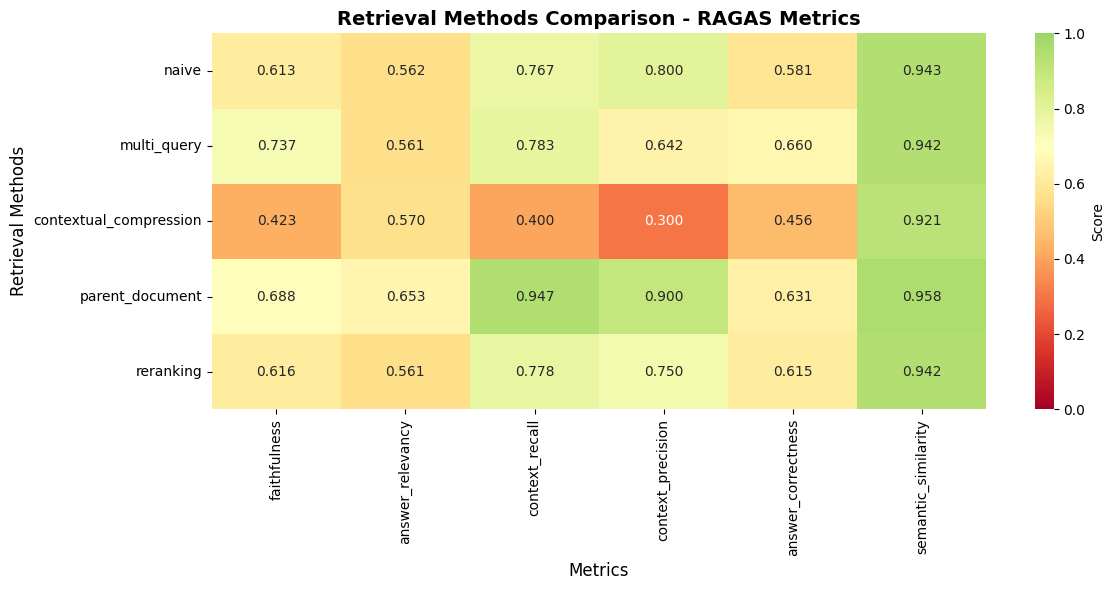


🏆 BEST METHOD PER METRIC:
--------------------------------------------------------------------------------
faithfulness..................          multi_query (0.7366)
answer_relevancy..............      parent_document (0.6530)
context_recall................      parent_document (0.9467)
context_precision.............      parent_document (0.9000)
answer_correctness............          multi_query (0.6601)
semantic_similarity...........      parent_document (0.9582)


In [32]:
# ============================================================================
# COMPARISON: Visualize All Methods
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_method_results).T
comparison_df.index.name = 'Method'
comparison_df = comparison_df.reset_index()

print("\n📊 COMPARISON TABLE:")
print("=" * 80)
display(comparison_df.round(4))

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    comparison_df.set_index('Method'),
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    center=0.7,
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Score'}
)
plt.title('Retrieval Methods Comparison - RAGAS Metrics', fontsize=14, weight='bold')
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Retrieval Methods', fontsize=12)
plt.tight_layout()
plt.show()

# Find best method for each metric
print("\n🏆 BEST METHOD PER METRIC:")
print("-" * 80)
for col in comparison_df.columns:
    if col != 'Method':
        best_idx = comparison_df[col].idxmax()
        best_method = comparison_df.loc[best_idx, 'Method']
        best_score = comparison_df.loc[best_idx, col]
        print(f"{col:.<30} {best_method:>20} ({best_score:.4f})")


📊 FINAL COMPARISON TABLE:


,Method,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness,semantic_similarity
0,naive,0.6134,0.5617,0.7667,0.8000,0.5813,0.9434
1,multi_query,0.7366,0.5610,0.7833,0.6417,0.6601,0.9422
2,contextual_compression,0.4234,0.5699,0.4005,0.3000,0.4563,0.9213
3,parent_document,0.6878,0.6530,0.9467,0.9000,0.6311,0.9582
4,reranking,0.6160,0.5612,0.7783,0.7500,0.6153,0.9418


✅ Heatmap saved to: metrics/visualizations/retrieval_comparison_heatmap.png


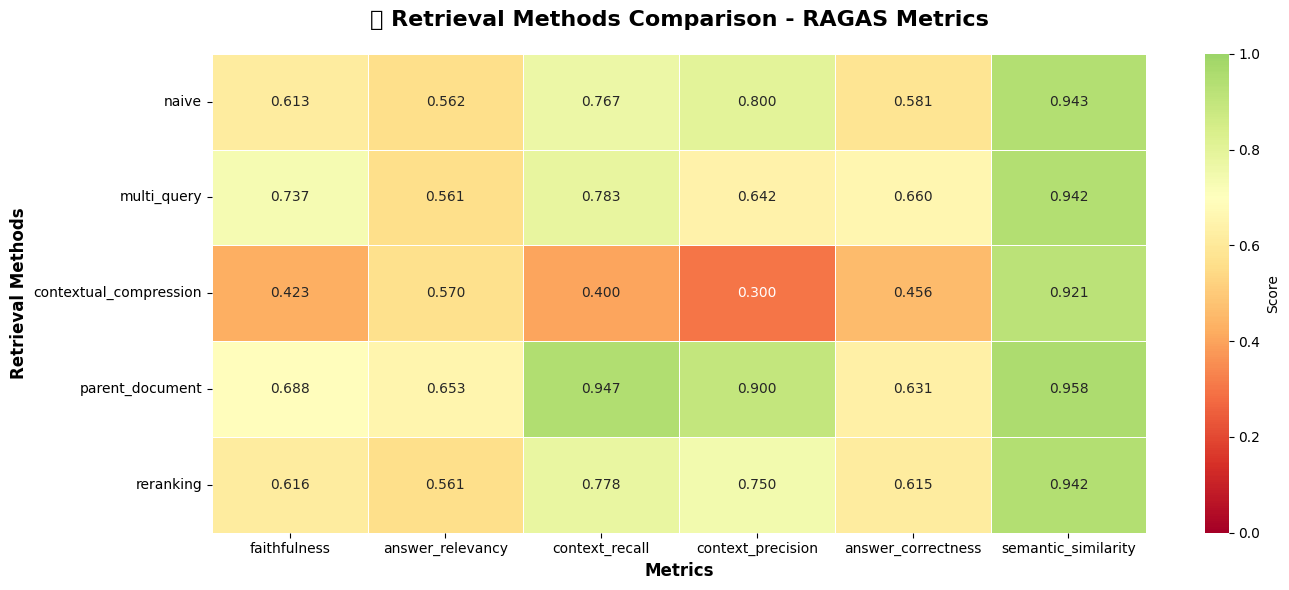

✅ Data saved to: metrics/ragas_evaluation_results.csv


In [33]:
# ============================================================================
# COMPARISON: Visualize All Methods (WITH SAVE)
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_method_results).T
comparison_df.index.name = 'Method'
comparison_df = comparison_df.reset_index()

print("\n📊 FINAL COMPARISON TABLE:")
print("=" * 80)
display(comparison_df.round(4))

# Create output directory
os.makedirs('/app/metrics/visualizations', exist_ok=True)

# Create heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    comparison_df.set_index('Method'),
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    center=0.7,
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Score'},
    linewidths=0.5
)
plt.title('🏆 Retrieval Methods Comparison - RAGAS Metrics', fontsize=16, weight='bold', pad=20)
plt.xlabel('Metrics', fontsize=12, weight='bold')
plt.ylabel('Retrieval Methods', fontsize=12, weight='bold')
plt.tight_layout()

# Save the figure
plt.savefig('/app/metrics/visualizations/retrieval_comparison_heatmap.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')
print("✅ Heatmap saved to: metrics/visualizations/retrieval_comparison_heatmap.png")

plt.show()

# Also save the data
comparison_df.to_csv('/app/metrics/ragas_evaluation_results.csv', index=False)
print("✅ Data saved to: metrics/ragas_evaluation_results.csv")